In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split,Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [ ]:
import os
import zipfile

# Define the path to your zip file
zip_path = '/content/drive/MyDrive/ffhqzipfile.zip'

# Define the extraction path
extract_path = '/content/drive/My Drive/dataset'

# Create the extraction directory if it does not exist
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    files_to_extract = zip_ref.namelist()[:10]
    for file in files_to_extract:
        zip_ref.extract(file, extract_path)

print(f'Test extraction complete. Check {extract_path} for extracted files.')

Test extraction complete. Check /content/drive/My Drive/dataset for extracted files.


In [ ]:

dataset = datasets.ImageFolder(
    root='/content/drive/My Drive/dataset',
    transform=transforms.ToTensor()
)



In [ ]:
# Define the split ratio for the subset
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) # Pass the dataset as the first argument

# Create dataloaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Training dataset size: 33816
Testing dataset size: 8455


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self.conv_block(feature * 2, feature))

        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = nn.functional.pad(x, [0, skip_connection.shape[3] - x.shape[3], 0, skip_connection.shape[2] - x.shape[2]])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_conv(x)

# Instantiate the model and optimizer
model = UNet(in_channels=3)  # Specify 3 input channels
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
 

In [ ]:
def add_noise(image, mask, noise_level):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image * (1 - mask) + noise * mask
    return noisy_image

In [ ]:
def train(model, dataloader, optimizer, epochs, noise_level):
    criterion = nn.MSELoss()
    model.train()
    epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in dataloader:
            optimizer.zero_grad()

            # Create a random mask
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1

            noisy_images = add_noise(images, mask, noise_level)
            outputs = model(noisy_images)

            loss = criterion(outputs * mask, images * mask)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}')

    return epoch_losses

In [ ]:
def denoise(model, noisy_image, mask):
    model.eval()

    with torch.no_grad():
        denoised_image = model(noisy_image)
        result_image = noisy_image * (1 - mask) + denoised_image * mask
    return result_image

Epoch [1/5], Loss: 0.2375


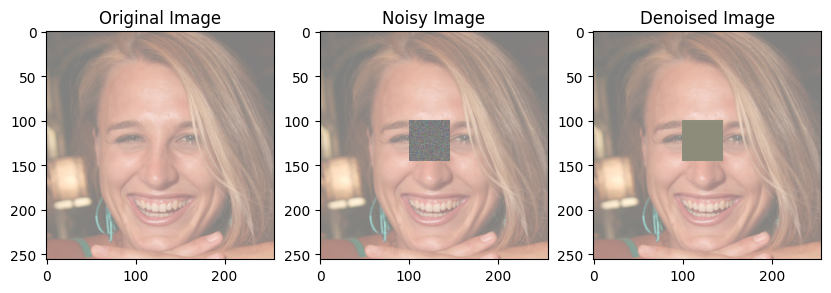

Epoch [2/5], Loss: 0.2164


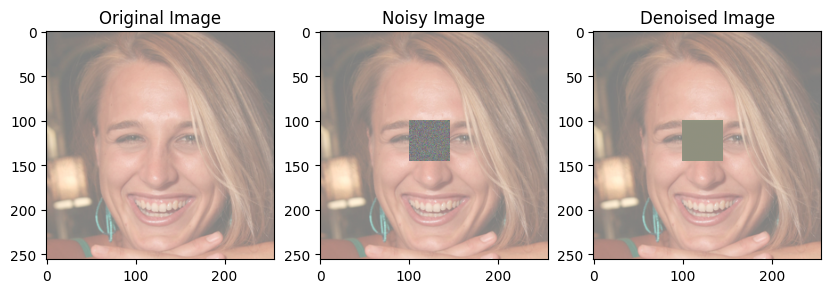

Epoch [3/5], Loss: 0.1881


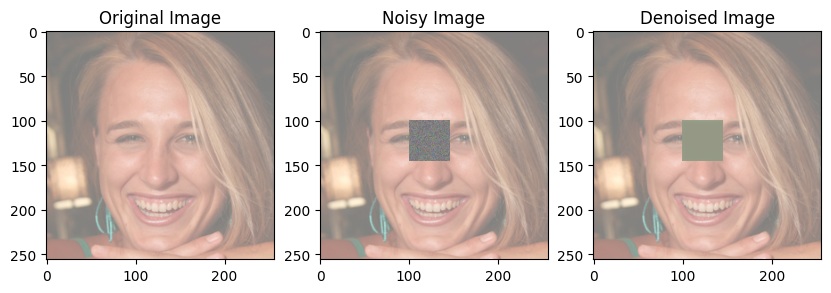

Epoch [4/5], Loss: 0.1324


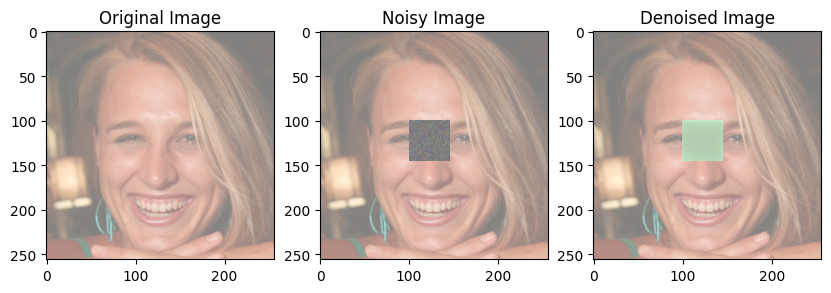

Epoch [5/5], Loss: 0.0954


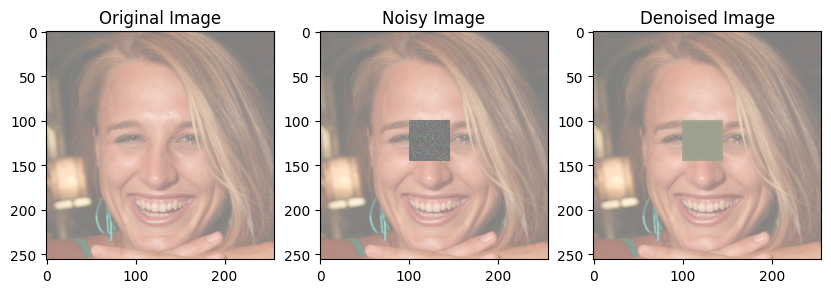

In [ ]:
def train(model, train_loader, optimizer, epochs=1, noise_level=0.1):
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for images, _ in train_loader:
            optimizer.zero_grad()
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1
            noisy_images = add_noise(images, mask, noise_level=noise_level)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()
        with torch.no_grad():
            test_image, _ = test_dataset[0]
            test_image = test_image.unsqueeze(0)
            mask = torch.zeros_like(test_image)
            mask[:, :, 100:146, 100:146] = 1
            noisy_image = add_noise(test_image, mask, noise_level=0.1)

            denoised_image = denoise(model, noisy_image, mask)

        # Display and save images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(np.transpose(test_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.subplot(1, 3, 2)
        plt.title("Noisy Image")
        plt.imshow(np.transpose(noisy_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.subplot(1, 3, 3)
        plt.title("Denoised Image")
        plt.imshow(np.transpose(denoised_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.savefig(f'epoch_{epoch+1}.png')
        plt.show()

# Instantiate the model and optimizer
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, optimizer, epochs=5, noise_level=0.1)

Epoch [1/5], Loss: 0.2618


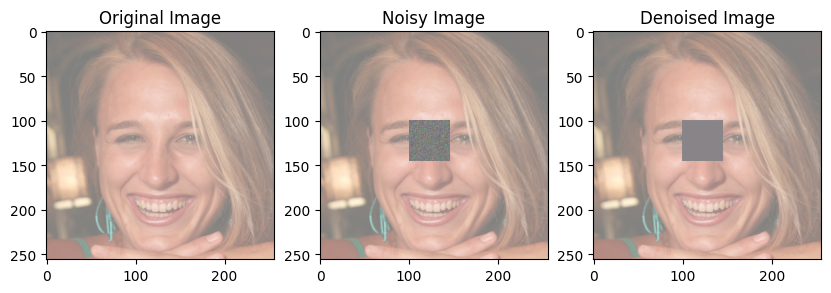

Epoch [2/5], Loss: 0.2004


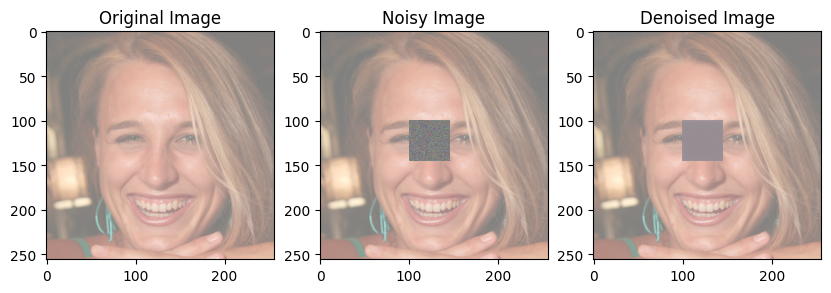

Epoch [3/5], Loss: 0.1008


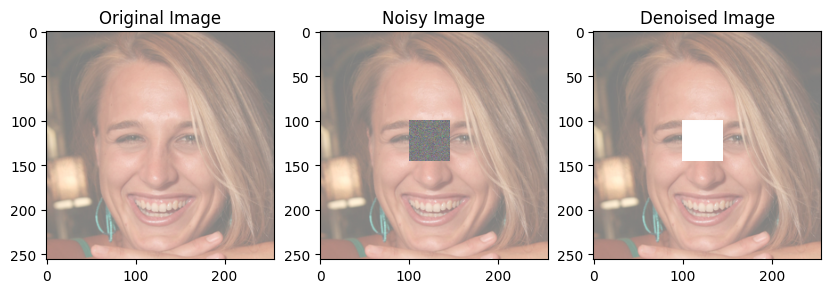

Epoch [4/5], Loss: 2.2351


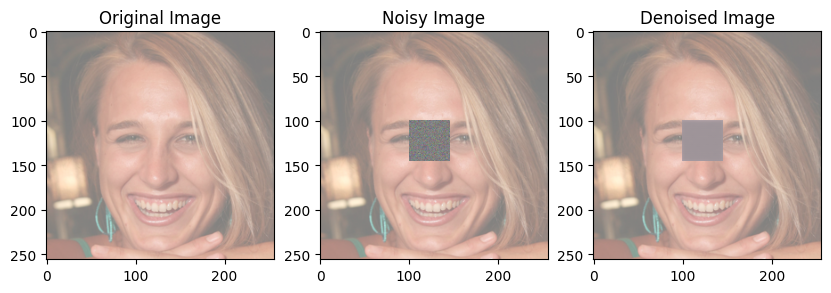

Epoch [5/5], Loss: 0.0597


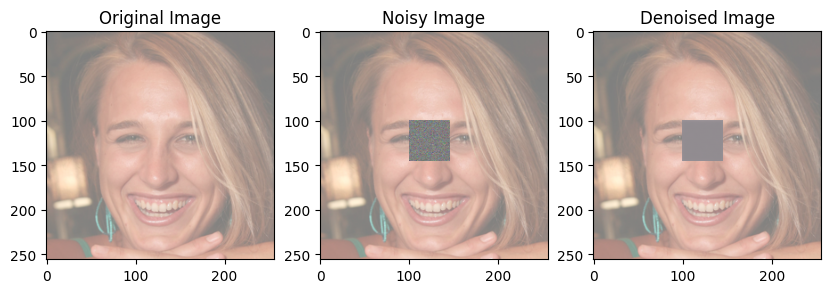

In [ ]:
def train(model, train_loader, optimizer, epochs=1, noise_level=0.1):
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for images, _ in train_loader:
            optimizer.zero_grad()
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1
            noisy_images = add_noise(images, mask, noise_level=noise_level)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()
        with torch.no_grad():
            test_image, _ = test_dataset[0]
            test_image = test_image.unsqueeze(0)
            mask = torch.zeros_like(test_image)
            mask[:, :, 100:146, 100:146] = 1
            noisy_image = add_noise(test_image, mask, noise_level=0.1)

            denoised_image = denoise(model, noisy_image, mask)

        # Display and save images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(np.transpose(test_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.subplot(1, 3, 2)
        plt.title("Noisy Image")
        plt.imshow(np.transpose(noisy_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.subplot(1, 3, 3)
        plt.title("Denoised Image")
        plt.imshow(np.transpose(denoised_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.savefig(f'epoch_{epoch+1}.png')
        plt.show()

# Instantiate the model and optimizer
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, optimizer, epochs=5, noise_level=0.1)

In [ ]:
# Initialize model and optimizer
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, optimizer, epochs=200, noise_level=0.1) # Removed block_size argument

# Test the model
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)
mask = torch.randn(test_image.shape).cuda()

Epoch [1/200], Loss: 0.007658627349883318
Epoch [2/200], Loss: 0.006645435467362404
Epoch [3/200], Loss: 0.004966454580426216
Epoch [4/200], Loss: 0.0023396944161504507
Epoch [5/200], Loss: 0.006295319646596909
Epoch [6/200], Loss: 0.0014643579488620162
Epoch [7/200], Loss: 0.0018450906500220299
Epoch [8/200], Loss: 0.00229591503739357
Epoch [9/200], Loss: 0.002475858898833394
Epoch [10/200], Loss: 0.002413638401776552
Epoch [11/200], Loss: 0.0021874781232327223
Epoch [12/200], Loss: 0.0018728667637333274
Epoch [13/200], Loss: 0.0015919302823022008
Epoch [14/200], Loss: 0.0014648676151409745
Epoch [15/200], Loss: 0.0015555089339613914
Epoch [16/200], Loss: 0.001738554215990007
Epoch [17/200], Loss: 0.0015882252482697368
Epoch [18/200], Loss: 0.001994710648432374
Epoch [19/200], Loss: 0.002011565724387765
Epoch [20/200], Loss: 0.0017214302206411958
Epoch [21/200], Loss: 0.0014846990816295147
Epoch [22/200], Loss: 0.0014592119259759784
Epoch [23/200], Loss: 0.0015522850444540381
Epoch [2

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
criterion = nn.MSELoss()

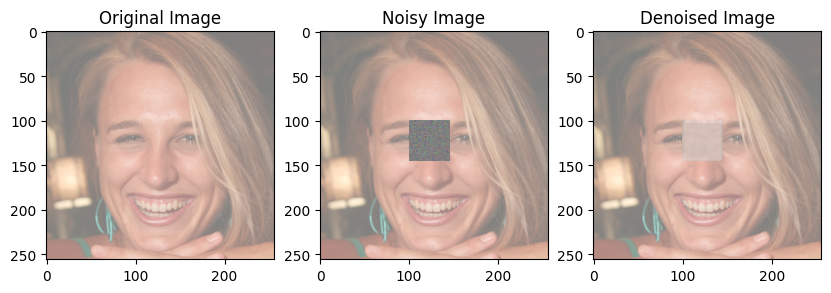

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    test_image, _ = test_dataset[0]
    test_image = test_image.unsqueeze(0)
    mask = torch.zeros_like(test_image)
    mask[:, :, 100:146, 100:146] = 1
    noisy_image = add_noise(test_image, mask, noise_level=0.1)
    denoised_image = denoise(model, noisy_image, mask)

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(np.transpose(test_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    plt.subplot(1, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(np.transpose(noisy_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(np.transpose(denoised_image.squeeze().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    plt.show()

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, epochs=1, noise_level=0.1):
    # ... (rest of the function code)

    return train_losses, val_losses

In [ ]:
def train(model, train_loader, test_loader, optimizer, epochs=1, noise_level=0.1):
    criterion = nn.MSELoss()
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            optimizer.zero_grad()
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1
            noisy_images = add_noise(images, mask, noise_level=noise_level)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in test_loader:
                mask = torch.zeros_like(images)
                mask[:, :, 100:146, 100:146] = 1
                noisy_images = add_noise(images, mask, noise_level=noise_level)
                outputs = model(noisy_images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        model.train()

    return train_losses, val_losses

In [ ]:
def compute_test_loss(model, test_loader, noise_level=0.1):
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1
            noisy_images = add_noise(images, mask, noise_level=noise_level)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    return test_loss

Epoch [1/25], Training Loss: 0.3169, Validation Loss: 0.2967
Epoch [2/25], Training Loss: 0.2691, Validation Loss: 0.2029
Epoch [3/25], Training Loss: 0.1853, Validation Loss: 0.0609
Epoch [4/25], Training Loss: 0.0624, Validation Loss: 0.0339
Epoch [5/25], Training Loss: 0.0368, Validation Loss: 0.0375
Epoch [6/25], Training Loss: 0.0404, Validation Loss: 0.0224
Epoch [7/25], Training Loss: 0.0272, Validation Loss: 0.0201
Epoch [8/25], Training Loss: 0.0253, Validation Loss: 0.0265
Epoch [9/25], Training Loss: 0.0310, Validation Loss: 0.0265
Epoch [10/25], Training Loss: 0.0311, Validation Loss: 0.0526
Epoch [11/25], Training Loss: 0.0536, Validation Loss: 0.0246
Epoch [12/25], Training Loss: 0.0291, Validation Loss: 0.0264
Epoch [13/25], Training Loss: 0.0302, Validation Loss: 0.0182
Epoch [14/25], Training Loss: 0.0224, Validation Loss: 0.0156
Epoch [15/25], Training Loss: 0.0198, Validation Loss: 0.0187
Epoch [16/25], Training Loss: 0.0227, Validation Loss: 0.0191
Epoch [17/25], Tr

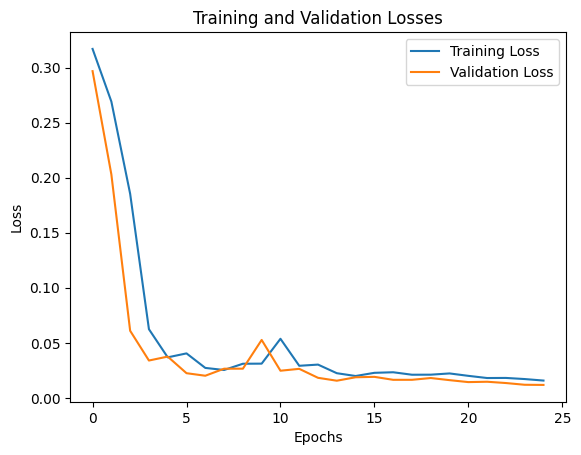

Test Loss: 0.0118


In [ ]:
# Instantiate the model and optimizer
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_losses = train(model, train_loader, test_loader, optimizer, epochs=25, noise_level=0.1)

# Plotting the training and validation losses
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Compute and print the test loss
test_loss = compute_test_loss(model, test_loader, noise_level=0.1)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Function to calculate PSNR
def calculate_psnr(original, denoised):
    original = original.detach().cpu().numpy().transpose(1, 2, 0)
    denoised = denoised.detach().cpu().numpy().transpose(1, 2, 0)
    return peak_signal_noise_ratio(original, denoised, data_range=denoised.max() - denoised.min())

# Function to calculate SSIM
def calculate_ssim(original, denoised):
    original = original.detach().cpu().numpy().transpose(1, 2, 0)
    denoised = denoised.detach().cpu().numpy().transpose(1, 2, 0)
    return structural_similarity(original, denoised, multichannel=True, data_range=denoised.max() - denoised.min())

# Evaluate model on test set
def evaluate_model(model, test_loader, noise_level=0.1):
    model.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for images, _ in test_loader:
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1
            noisy_images = add_noise(images, mask, noise_level=noise_level)
            outputs = model(noisy_images)

            for i in range(len(images)):
                psnr = calculate_psnr(images[i], outputs[i])
                ssim = calculate_ssim(images[i], outputs[i])
                psnr_values.append(psnr)
                ssim_values.append(ssim)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Average PSNR: {avg_psnr:.4f}')
    print(f'Average SSIM: {avg_ssim:.4f}')

    return avg_psnr, avg_ssim

# Call the evaluation function
avg_psnr, avg_ssim = evaluate_model(model, test_loader)


Average PSNR: 20.1025
Average SSIM: 0.7576


<ipython-input-34-0ff8fb879e40>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(original, denoised, multichannel=True, data_range=denoised.max() - denoised.min())


In [ ]:
import torch
import numpy as np

# Function to calculate MSE
def calculate_mse(original, denoised):
    mse = torch.nn.functional.mse_loss(denoised, original)
    return mse.item()

# Function to calculate MAE
def calculate_mae(original, denoised):
    mae = torch.nn.functional.l1_loss(denoised, original)
    return mae.item()

# Evaluate model on test set
def evaluate_model_with_errors(model, test_loader, noise_level=0.1):
    model.eval()
    mse_values = []
    mae_values = []

    with torch.no_grad():
        for images, _ in test_loader:
            mask = torch.zeros_like(images)
            mask[:, :, 100:146, 100:146] = 1
            noisy_images = add_noise(images, mask, noise_level=noise_level)
            outputs = model(noisy_images)

            for i in range(len(images)):
                mse = calculate_mse(images[i], outputs[i])
                mae = calculate_mae(images[i], outputs[i])
                mse_values.append(mse)
                mae_values.append(mae)

    avg_mse = np.mean(mse_values)
    avg_mae = np.mean(mae_values)

    print(f'Average MSE: {avg_mse:.4f}')
    print(f'Average MAE: {avg_mae:.4f}')

    return avg_mse, avg_mae

# Call the evaluation function
avg_mse, avg_mae = evaluate_model_with_errors(model, test_loader)


Average MSE: 0.0118
Average MAE: 0.0831
